In [329]:
import time
import json
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy

# Euroleaks
- document = uninterrupted speech made by speaker (this is similar to the Ferrara et al. approach with ECB hearings)

## LDA author topic model
Author can be either speaker (entity) or date. 

In [573]:
# parameters

author = 'entity' # 'date' or 'entity'
POS_filter = 'content' # 'content' or 'nouns'

### preprocessing

In [574]:
# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)
    
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

In [575]:
if POS_filter == 'content':
    filter_POS = {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}
elif POS_filter == 'nouns':
    filter_POS = {'NOUN', 'PROPN'}

def filter_token(token):
    return token.pos_ in filter_POS\
        and not token.lemma_.lower() in nlp.Defaults.stop_words\
        and not token.lower_ in stopwords['names']\
        and not token.lower_ in stopwords['disfluency']\
        and not token.lemma_.lower() in stopwords['courtesy']\
        and len(token.lemma_) > 1

In [576]:
# read data
df = pd.read_csv('../data/euroleaks/squeezed.csv')


# add column for entity, label unassigned as Unidentified
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)
df['entity'] = df.speaker.apply(lambda s: speaker_to_entity[s] if s in speaker_to_entity.keys() else 'Unidentified')


# preprocess
documents = [
    [token.lemma_.lower() for token in nlp(doc) if filter_token(token)]
    for doc in df.speech.values 
]

# get labels (important that this is done BEFORE removing documents)
dates = [pd.to_datetime(date).strftime('%d/%m') for date,d in zip(df.date, documents) if len(d) > 0]
entities = [entity for entity,d in zip(df.entity, documents) if len(d) > 0]

# leave out empty documents
documents = [d for d in documents if len(d) > 0]

# apply collocations
documents = [
    apply_bigram_colloc(apply_trigram_colloc(' '.join(doc), trigram_colloc), bigram_colloc).split()
    for doc in documents]

In [577]:
np.unique(dates)

array(['01/04', '01/07', '11/05', '17/03', '18/06', '22/06', '24/02',
       '24/04', '24/06', '25/06', '27/06', '30/06'], dtype='<U5')

In [578]:
print(f'There are a total of {np.sum([len(doc) for doc in documents])} tokens, and a total of {len(documents)} documents.')

There are a total of 27170 tokens, and a total of 538 documents.


### dictionary: filter extremes

In [579]:
from gensim.corpora import Dictionary

dictionary = Dictionary(documents)

no_below=2
no_above=.1

# see what will be removed
no_below_removed = [dictionary.get(token_id) for token_id, freq in dictionary.cfs.items() if freq < no_below]
no_above_removed = [dictionary.get(token_id) for token_id, freq in dictionary.dfs.items() if freq > no_above * len(documents)]

print(f'no_below will remove {len(no_below_removed)} tokens.')
print(f'no_above will remove {len(no_above_removed)} tokens.')

dictionary.filter_extremes(
    no_below=no_below,  # Keep tokens which are contained in at least no_below documents.
    no_above=no_above # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
)

no_below will remove 1429 tokens.
no_above will remove 41 tokens.


In [580]:
# bag of words
corpus = [dictionary.doc2bow(text) for text in documents]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1856
Number of documents: 538


### author2doc

In [581]:
from collections import defaultdict

author2doc = defaultdict(list)

if author == 'date':
    for i,date in enumerate(dates):
        author2doc[date].append(i)
elif author == 'entity':
    for i,entity in enumerate(entities):
        author2doc[entity].append(i)

### grid search

In [582]:
import multiprocessing
n_cores = multiprocessing.cpu_count() - 1

from gensim.models import CoherenceModel
from gensim.models import AuthorTopicModel
from gensim.test.utils import temporary_file

In [584]:
def compute_coherence_values(corpus, dictionary, num_topics, alpha, beta):
     
    with temporary_file("serialized") as s_path:
    
        author_model = AuthorTopicModel(
                        corpus=corpus,
                        author2doc=author2doc,
                        id2word=dictionary,
                        num_topics=num_topics,
                        serialized=True,
                        serialization_path=s_path,
                        iterations=200,
                        passes=10,
                        alpha=alpha,
                        eta=beta,
                        random_state=101
                        )

        author_model.update(corpus, author2doc)
    
    
    coherence_model_umass = CoherenceModel(model=author_model,
                                         corpus=corpus, 
                                         coherence='u_mass')
    
#     coherence_model_cv = CoherenceModel(model=author_model,
#                                          texts=documents, 
#                                          coherence='c_v')
    
#     return (coherence_model_umass.get_coherence(), coherence_model_cv.get_coherence())
    return coherence_model_umass.get_coherence()

In [585]:
# test run

t = time.time()

umass = compute_coherence_values(corpus, dictionary, 3, 1, 1)

time_taken = round((time.time() - t) / 60, 2)
print(f'Time taken: {time_taken} mins')

print(f'u_mass: {umass}\nc_v: {cv}')

Time taken: 0.09 mins
u_mass: -1.3751306492599653
c_v: -2.6070831196239643


In [586]:
# k = number of topics hyperparameter
topics_range = range(2,6)

# alpha hyperparameter
alpha = [.01, .3, 1]
alpha.append('symmetric')
alpha.append('asymmetric')

# beta hyperparameter
beta = [.01, .3, 1]
beta.append('symmetric')


model_results = {'num_topics': [],
                 'alpha': [],
                 'beta': [],
                 'u_mass': [],
                }

number_of_runs = len(topics_range) * len(alpha) * len(beta)
print(f'You are about to execute {number_of_runs} runs. This could take up to {np.round(number_of_runs*time_taken,2)} minutes.')

You are about to execute 80 runs. This could take up to 7.2 minutes.


In [587]:
import tqdm

with tqdm.tqdm(total=number_of_runs) as pbar:

    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                
                umass = compute_coherence_values(corpus=corpus,
                                                       dictionary=dictionary, 
                                                       num_topics=k,
                                                       alpha=a,
                                                       beta=b)
                    
                # save the model results
                model_results['num_topics'].append(k)
                model_results['alpha'].append(a)
                model_results['beta'].append(b)
                model_results['u_mass'].append(np.mean(umass))

                # update process bar
                pbar.update(1)
                
pd.DataFrame(model_results).to_csv(f'../data/lda-grid-search/stm-euroleaks-doc_{author}-2.csv', index=False)

100%|██████████| 80/80 [04:47<00:00,  3.60s/it]


### inspect results

In [246]:
# import os

# listing = os.listdir('../data/lda-grid-search')
# for filename in listing:
#     print(filename)

In [588]:
results = pd.read_csv('../data/lda-grid-search/stm-euroleaks-doc_entity-2.csv')

results.sort_values(by='u_mass', ascending=False)

,num_topics,alpha,beta,u_mass
30,3,1,1,-1.375131
49,4,1,0.3,-1.390550
50,4,1,1,-1.416687
51,4,1,symmetric,-1.419198
20,3,0.01,0.01,-1.441977
...,...,...,...,...
56,4,asymmetric,0.01,-2.496839
59,4,asymmetric,symmetric,-3.286099
78,5,asymmetric,1,-3.364709
57,4,asymmetric,0.3,-3.567376


In [235]:
# fig, axes = plt.subplots(1,2, figsize=(10,4))

# y1 = results.groupby('num_topics').u_mass.max()
# y2 = results.groupby('num_topics').c_v.max()

# axes[0].plot(y1, marker='+', label='u_mass')
# axes[0].set_title('u_mass')

# axes[1].plot(y2, marker='o', label='c_v')
# axes[1].set_title('c_v')

#_ = ax.set_xticks(results.groupby('num_topics').c_v.mean().index)

### best model

In [589]:
results = pd.read_csv(f'../data/lda-grid-search/stm-euroleaks-doc_{author}.csv')

best = results.iloc[results.u_mass.argmax()]

best_alpha = best['alpha'] if 'symmetric' in best['alpha'] else float(best['alpha'])
best_beta = best['beta'] if 'symmetric' in best['beta'] else float(best['beta'])

num_topics = int(best[0])
expected_u_mass = float(best[-1])

In [590]:
with temporary_file("serialized") as s_path:

    author_model = AuthorTopicModel(
                    corpus=corpus,
                    author2doc=author2doc,
                    id2word=dictionary,
                    num_topics=num_topics,
                    serialized=True,
                    serialization_path=s_path,
                    iterations=200,
                    passes=10,
                    alpha=best_alpha,
                    eta=best_beta,
                    random_state=100
                    )

    author_model.update(corpus, author2doc)


coherence_model_umass = CoherenceModel(model=author_model,
                                     corpus=corpus, 
                                     coherence='u_mass')

print(coherence_model_umass.get_coherence())
#assert np.isclose(coherence_model_umass.get_coherence(), expected_u_mass)

-1.477276806739293


In [591]:
from pprint import pprint

pprint(author_model.print_topics(num_words=30))

[(0,
  '0.008*"policy" + 0.008*"reform" + 0.007*"area" + 0.007*"number" + '
  '0.006*"bank" + 0.006*"document" + 0.005*"fiscal" + 0.005*"general" + '
  '0.005*"liquidity" + 0.004*"list" + 0.004*"detail" + 0.004*"market" + '
  '0.004*"authority" + 0.004*"progress" + 0.004*"debt" + 0.004*"problem" + '
  '0.004*"include" + 0.004*"start" + 0.004*"technical" + 0.003*"position" + '
  '0.003*"provide" + 0.003*"actually" + 0.003*"review" + 0.003*"forward" + '
  '0.003*"direction" + 0.003*"financial" + 0.003*"fully" + 0.003*"important" + '
  '0.003*"growth" + 0.003*"interest_rate"'),
 (1,
  '0.008*"list" + 0.008*"referendum" + 0.007*"political" + 0.007*"letter" + '
  '0.006*"decision" + 0.006*"use" + 0.006*"statement" + 0.006*"different" + '
  '0.005*"try" + 0.005*"start" + 0.005*"possible" + 0.005*"country" + '
  '0.005*"thing" + 0.005*"conclusion" + 0.005*"minister" + 0.005*"basis" + '
  '0.004*"maybe" + 0.004*"hear" + 0.004*"reach" + 0.004*"final" + '
  '0.004*"fully" + 0.004*"position" + 0.

In [558]:
top_n = 10
topic_labels = [' '.join(np.array(author_model.show_topic(i,top_n))[:,0]) for i in range(num_topics)]
topic_labels

['reform pension debt policy fiscal tax low important parliament increase',
 'list reform liquidity progress country believe month negotiation bank number',
 'document list letter political problem position statement understand decision basis']

In [406]:
# import re

# first_n = 20

# topic_sep = re.compile(r'0\.[0-9]{3}\*"|"')

# model_topics = np.array([re.sub(topic_sep , '', model_topic).
#     split(' + ') for topic_no , model_topic in author_model.print_topics(num_words=first_n)])

In [433]:
topic_corpus = [author_model.get_author_topics(author) for author in author2doc.keys()]

topic_proportions = pd.DataFrame(np.zeros((len(topic_corpus), 3)))

for i,doc in enumerate(topic_corpus):
    for topic in doc:
        topic_proportions.iloc[i,topic[0]] = topic[1]
    
topic_proportions.set_index(pd.Series(list(author2doc.keys())), inplace=True)
topic_proportions.rename(columns={i:t for i,t in enumerate(topic_labels)}, inplace=True)

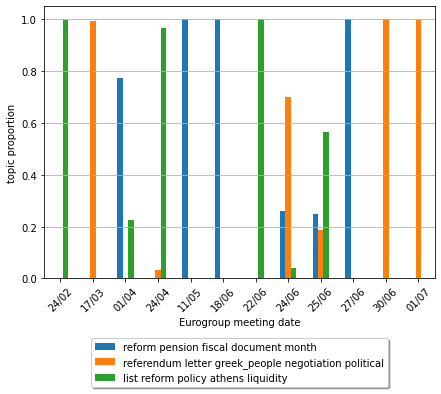

In [418]:
# author = date
#date_topic_proportions = topic_proportions.copy()

fig, ax = plt.subplots(figsize=(7,6))

date_topic_proportions.sort_index().plot.bar(ax=ax, label=topic_labels)
ax.set_xticklabels(date_topic_proportions.index, rotation=45)
#ax.legend()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=1, )

ax.set_ylabel('topic proportion')
ax.set_xlabel('Eurogroup meeting date')
ax.grid(axis='y')

#ig.tight_layout()
fig.subplots_adjust(bottom=0.25)
fig.savefig('../figures/stm-leaks-dates.png')

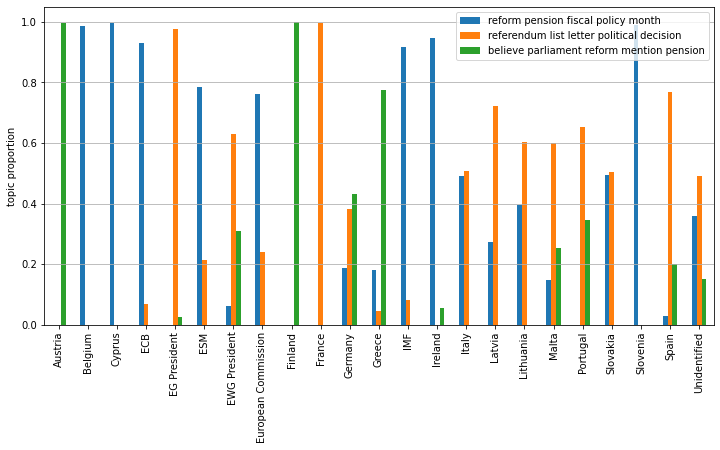

In [499]:
# author = entity
entity_topic_proportions = topic_proportions.copy()

fig, ax = plt.subplots(figsize=(12,7))

entity_topic_proportions.sort_index().plot.bar(ax=ax, label=topic_labels)
#ax.set_xticklabels(entity_topic_proportions.index, rotation=45)
#ax.legend()
#ax.legend(loc='upper center', bbox_to_anchor=(0.6, -0.2), shadow=True, ncol=1, )

ax.set_ylabel('topic proportion')
#ax.set_xlabel('Eurogroup meeting date')
ax.grid(axis='y')

#ig.tight_layout()
fig.subplots_adjust(bottom=0.25)
fig.savefig('../figures/stm-leaks-dates.png')

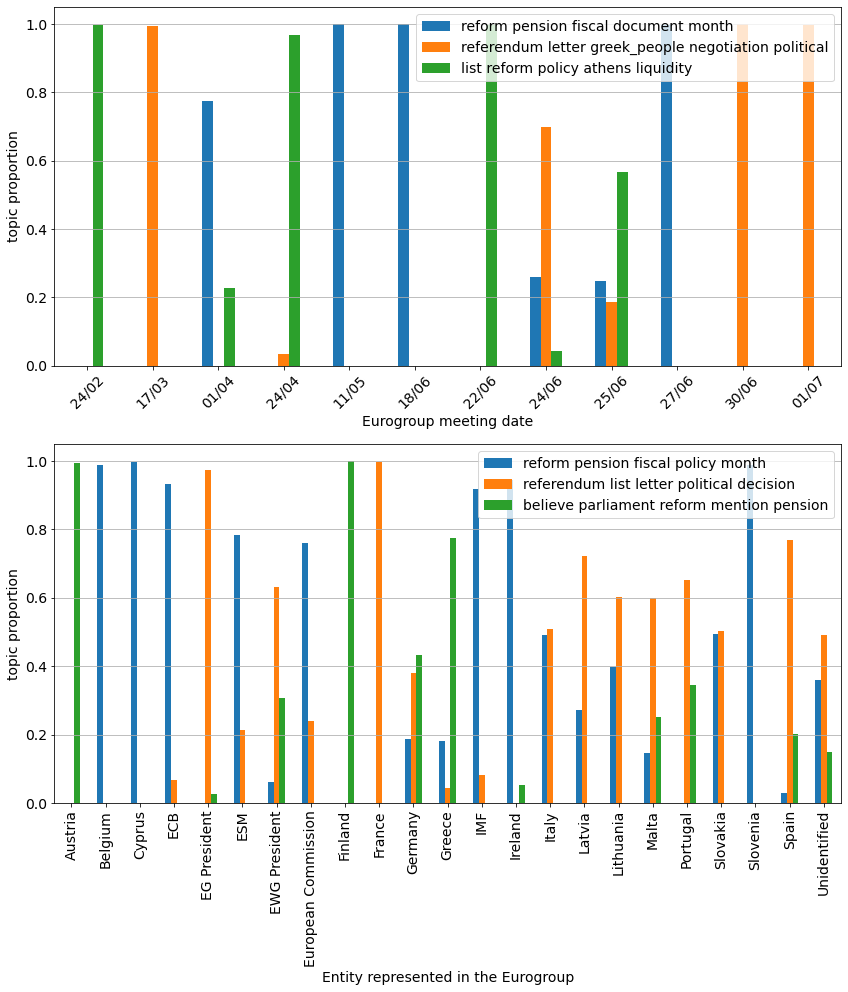

In [517]:
fig, axes = plt.subplots(2,1,figsize=(12,14))

plt.rc('font', size=14)

date_topic_proportions.sort_index().plot.bar(ax=axes[0])
axes[0].set_xticklabels(date_topic_proportions.index, rotation=45)
axes[0].grid(axis='y')
axes[0].set_ylabel('topic proportion')
axes[0].set_xlabel('Eurogroup meeting date')

entity_topic_proportions.sort_index().plot.bar(ax=axes[1], label=topic_labels)
axes[1].grid(axis='y')
axes[1].set_ylabel('topic proportion')
axes[1].set_xlabel('Entity represented in the Eurogroup')

#ax.set_ylabel('topic proportion')
#ax.set_xlabel('Eurogroup meeting date')
ax.grid(axis='y')

fig.tight_layout()
fig.savefig('../figures/stm-joint.png')

## LDA doc=speech

### dictionary: filter extremes

In [70]:
from gensim.models import LdaMulticore, TfidfModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import multiprocessing

In the ECB study, Ferrara et al. also use no_below = 2.

In [71]:
dictionary = Dictionary(documents)

no_below = 2 # Keep only tokens which are contained in at least no_below documents.
no_above = .1 # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).

In [72]:
# see what will be removed
no_below_removed = [dictionary.get(token_id) for token_id, freq in dictionary.cfs.items() if freq < no_below]
no_above_removed = [dictionary.get(token_id) for token_id, freq in dictionary.dfs.items() if freq > no_above * len(documents)]

print(f'no_below will remove {len(no_below_removed)} tokens.')
print(f'no_above will remove {len(no_above_removed)} tokens.')

no_below will remove 1429 tokens.
no_above will remove 41 tokens.


In [73]:
dictionary.filter_extremes(
    no_below=no_below,
    no_above=no_above
)

In [74]:
# vanilla bag of words
corpus = [dictionary.doc2bow(text) for text in documents]

In [75]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1856
Number of documents: 538


### basic model

In [17]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [18]:
t = time.time()

lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=6, 
                         random_state=100,
                         iterations=200,
                         passes=10,
                         alpha=.1,
                         eta=.1,
                        )

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.06 mins


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#pyLDAvis.enable_notebook()
#gensimvis.prepare(lda_model, corpus, dictionary)

In [ ]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=20))

In [ ]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus,
                                     coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

### grid search: k, alpha, beta

In [20]:
# supporting function
def compute_coherence_values(corpus, dictionary, num_topics, alpha, beta):
    
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             iterations=200,
                             passes=10,
                             alpha=alpha,
                             eta=beta,
                             random_state=100)
    
    coherence_model_umass = CoherenceModel(model=lda_model,
                                         corpus=corpus, 
                                         coherence='u_mass')
    
    coherence_model_cv = CoherenceModel(model=lda_model,
                                         texts=documents, 
                                         coherence='c_v')
    
    return (coherence_model_umass.get_coherence(), coherence_model_cv.get_coherence())

In [21]:
# k = number of topics hyperparameter
topics_range = range(2,21)

# alpha hyperparameter
alpha = [.01, .3, .6, 1]
alpha.append('symmetric')
alpha.append('asymmetric')

# beta hyperparameter
beta = [.01, .3, .6, 1]
beta.append('symmetric')


model_results = {'num_topics': [],
                 'alpha': [],
                 'beta': [],
                 'u_mass': [],
                 'c_v': []
                }

number_of_runs = len(topics_range) * len(alpha) * len(beta)
print(f'You are about to execute {number_of_runs} runs. This could take up to {np.round(number_of_runs*0.06,2)} minutes.')

You are about to execute 570 runs. This could take up to 34.2 minutes.


In [22]:
import tqdm

with tqdm.tqdm(total=number_of_runs) as pbar:

    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                umass, cv = compute_coherence_values(corpus=corpus,
                                                     dictionary=dictionary, 
                                                     num_topics=k,
                                                     alpha=a,
                                                     beta=b)
                # save the model results
                model_results['num_topics'].append(k)
                model_results['alpha'].append(a)
                model_results['beta'].append(b)
                model_results['u_mass'].append(umass)
                model_results['c_v'].append(cv)

                # update process bar
                pbar.update(1)
                
pd.DataFrame(model_results).to_csv(f'../data/lda-grid-search/euroleaks-doc_speech-{POS_filter}.csv', index=False)

100%|██████████| 570/570 [49:47<00:00,  5.24s/it]


### best model

In [76]:
import os

listing = os.listdir('../data/lda-grid-search')
for filename in listing:
    print(filename)

euroleaks-doc_entity-nouns.csv
euroleaks-doc_entity-content.csv
euroleaks-dentity-nouns.csv
euroleaks-doc_speech-content.csv
euroleaks-doc_speech-nouns.csv


In [77]:
results = pd.read_csv(f'../data/lda-grid-search/euroleaks-doc_speech-{POS_filter}.csv')
print(f'POS filter: {POS_filter}')

results.sort_values(by='u_mass', ascending=False).head(10)

POS filter: content


,num_topics,alpha,beta,u_mass,c_v
55,3,asymmetric,0.01,-1.434143,0.264034
8,2,0.3,1,-1.493507,0.280311
7,2,0.3,0.6,-1.494860,0.271524
9,2,0.3,symmetric,-1.500617,0.271524
3,2,0.01,1,-1.513423,0.286903
6,2,0.3,0.3,-1.516607,0.267734
4,2,0.01,symmetric,-1.522851,0.285916
23,2,symmetric,1,-1.525237,0.315435
2,2,0.01,0.6,-1.528629,0.298404
22,2,symmetric,0.6,-1.529206,0.295806


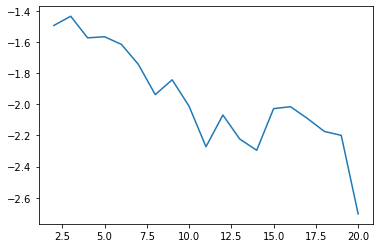

In [78]:
plt.plot(results.groupby('num_topics').u_mass.max())

In [79]:
best = results.iloc[np.argmax(results.u_mass)]
best

num_topics             3
alpha         asymmetric
beta                0.01
u_mass         -1.434143
c_v             0.264034
Name: 55, dtype: object

In [80]:
# find best combination of hyperparams
#best = results.iloc[np.argmax(results['coherence'])]
#best

In [81]:
best_alpha = best['alpha'] if 'symmetric' in best['alpha'] else float(best['alpha'])
best_beta = best['beta'] if 'symmetric' in best['beta'] else float(best['beta'])

In [82]:
# train basic LDA model with those hyperparameters

lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=best['num_topics'],
                         alpha=best_alpha,
                         eta=best_beta,
                         iterations=200,
                         passes=10,
                         random_state=100
                        )


# get coherence per topic

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus, 
                                     coherence='u_mass')

print(coherence_model_lda.get_coherence())

-1.434142697566876


In [84]:
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.006*"document" + 0.006*"use" + 0.006*"policy" + 0.006*"fiscal" + '
  '0.005*"number" + 0.005*"bank" + 0.005*"statement" + 0.005*"set" + '
  '0.005*"progress" + 0.005*"liquidity"'),
 (1,
  '0.014*"list" + 0.009*"decision" + 0.007*"country" + 0.007*"hear" + '
  '0.007*"start" + 0.006*"different" + 0.006*"referendum" + 0.006*"political" '
  '+ 0.006*"fully" + 0.006*"order"'),
 (2,
  '0.018*"reform" + 0.015*"pension" + 0.009*"month" + 0.008*"propose" + '
  '0.008*"parliament" + 0.007*"tax" + 0.006*"problem" + 0.006*"greek_people" + '
  '0.006*"year" + 0.005*"mention"')]


In [91]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#pyLDAvis.enable_notebook()
#gensimvis.prepare(lda_model, corpus, dictionary)

/Users/asajina/repos/master-thesis/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### figure

In [85]:
term_topic_matrix = lda_model.get_topics()
term_topic_matrix.shape

(3, 1856)

In [86]:
np.max(term_topic_matrix[0])

0.0061640805

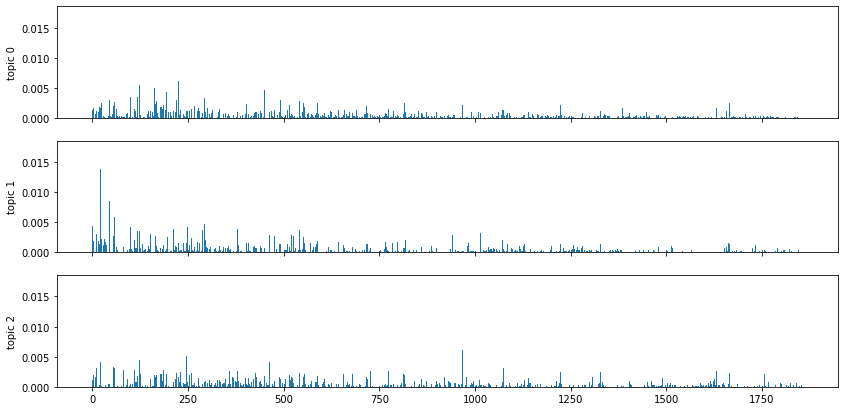

In [87]:
fig, axes = plt.subplots(best['num_topics'], 1, sharex=True, sharey=True, figsize=(14,7))

x = range(len(dictionary))

for i, ax in enumerate(axes):
    ax.bar(range(len(term_topic_matrix[i])), term_topic_matrix[i], width=.8)
    ax.set_ylabel(f'topic {i}')
    #ax.set_yticks([])
    #ax.set_xticks([])

In [95]:
import re

first_n = 15

topic_sep = re.compile(r'0\.[0-9]{3}\*"|"')

model_topics = np.array([re.sub(topic_sep , '', model_topic).
    split(' + ') for topic_no , model_topic in lda_model.print_topics(num_words=first_n)])

model_topics

array([['document', 'use', 'policy', 'fiscal', 'number', 'bank',
        'statement', 'set', 'progress', 'liquidity', 'month', 'debt',
        'level', 'letter', 'reform'],
       ['list', 'decision', 'country', 'hear', 'start', 'different',
        'referendum', 'political', 'fully', 'order', 'thing',
        'comprehensive', 'try', 'minister', 'reform'],
       ['reform', 'pension', 'month', 'propose', 'parliament', 'tax',
        'problem', 'greek_people', 'year', 'mention', 'short', 'believe',
        'state', 'fiscal', 'debt']], dtype='<U13')

In [97]:
for row in model_topics.T:
    print(f'{row[0]} & {row[1]} & {row[2]}', end='')
    print('\\\\')

document & list & reform\\
use & decision & pension\\
policy & country & month\\
fiscal & hear & propose\\
number & start & parliament\\
bank & different & tax\\
statement & referendum & problem\\
set & political & greek_people\\
progress & fully & year\\
liquidity & order & mention\\
month & thing & short\\
debt & comprehensive & believe\\
level & try & state\\
letter & minister & fiscal\\
reform & reform & debt\\


In [98]:
# first_n = 10

# # pretty print
# import re
# topic_sep = re.compile(r"0\.[0 -9]{3}\*")

# model_topics = [( topic_no , re.sub(topic_sep , '', model_topic).
#     split(' + ')) for topic_no , model_topic in
#         author_model.print_topics(num_topics=num_topics,
#     num_words=first_n)]

# descriptors = []
# for i, m in model_topics:
#     print(i, ", ".join(m[:first_n]))
#     descriptors.append(", ".join(m[:2]).replace('"', ''))

# LDA doc=date

In [104]:
# parameters
POS_filter = 'content' # 'content' or 'nouns'

### preprocessing

In [105]:
# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)
    
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

In [106]:
if POS_filter == 'content':
    filter_POS = {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}
elif POS_filter == 'nouns':
    filter_POS = {'NOUN', 'PROPN'}

def filter_token(token):
    return token.pos_ in filter_POS\
        and not token.lemma_.lower() in nlp.Defaults.stop_words\
        and not token.lower_ in stopwords['names']\
        and not token.lower_ in stopwords['disfluency']\
        and not token.lemma_.lower() in stopwords['courtesy']\
        and len(token.lemma_) > 1

In [107]:
# read data
df = pd.read_csv('../data/euroleaks/squeezed.csv')

# group by date
grouped = df.drop(columns=['speaker']).groupby('date').apply(lambda s: ' '.join(s.speech))
# get speaker labels
dates = grouped.index

# preprocess
documents = [
    [token.lemma_.lower() for token in nlp(doc) if filter_token(token)]
    for doc in grouped.values 
]


# leave out empty documents
documents = [d for d in documents if len(d) > 0]


# get labels
dates = [pd.to_datetime(date).strftime('%d/%m') for date,d in zip(df.date, documents) if len(d) > 0]
entities = [entity for entity,d in zip(df.entity, documents) if len(d) > 0]


# apply collocations
documents = [
    apply_bigram_colloc(apply_trigram_colloc(' '.join(doc), trigram_colloc), bigram_colloc).split()
    for doc in documents]

In [108]:
print(f'There are a total of {np.sum([len(doc) for doc in documents])} tokens, and a total of {len(documents)} documents.')

There are a total of 27161 tokens, and a total of 12 documents.


### dictionary: filter extremes

In [140]:
from gensim.corpora import Dictionary

dictionary = Dictionary(documents)

no_below=2
no_above=.95

# see what will be removed
no_below_removed = [dictionary.get(token_id) for token_id, freq in dictionary.cfs.items() if freq < no_below]
no_above_removed = [dictionary.get(token_id) for token_id, freq in dictionary.dfs.items() if freq > no_above * len(documents)]

print(f'no_below will remove {len(no_below_removed)} tokens.')
print(f'no_above will remove {len(no_above_removed)} tokens.')

dictionary.filter_extremes(
    no_below=no_below,  # Keep tokens which are contained in at least no_below documents.
    no_above=no_above # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
)

no_below will remove 1425 tokens.
no_above will remove 57 tokens.


In [141]:
# bag of words
corpus = [dictionary.doc2bow(text) for text in documents]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1723
Number of documents: 12


In [126]:
# test

t = time.time()

lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=6, 
                         random_state=100,
                         iterations=200,
                         passes=10,
                         alpha=.1,
                         eta=.1,
                        )

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.07 mins


### grid search: k, alpha, beta

In [127]:
# supporting function
def compute_coherence_values(corpus, dictionary, num_topics, alpha, beta):
    
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             iterations=200,
                             passes=10,
                             alpha=alpha,
                             eta=beta,
                             random_state=100)
    
    coherence_model_umass = CoherenceModel(model=lda_model,
                                         corpus=corpus, 
                                         coherence='u_mass')
    
    return coherence_model_umass.get_coherence()

In [128]:
# k = number of topics hyperparameter
topics_range = range(2,21)

# alpha hyperparameter
alpha = [.01, .3, .6, 1]
alpha.append('symmetric')
alpha.append('asymmetric')

# beta hyperparameter
beta = [.01, .3, .6, 1]
beta.append('symmetric')


model_results = {'num_topics': [],
                 'alpha': [],
                 'beta': [],
                 'u_mass': []
                }

number_of_runs = len(topics_range) * len(alpha) * len(beta)
print(f'You are about to execute {number_of_runs} runs. This could take up to {np.round(number_of_runs*0.07,2)} minutes.')

You are about to execute 570 runs. This could take up to 39.9 minutes.


In [129]:
import tqdm

with tqdm.tqdm(total=number_of_runs) as pbar:

    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                umass = compute_coherence_values(corpus=corpus,
                                                     dictionary=dictionary, 
                                                     num_topics=k,
                                                     alpha=a,
                                                     beta=b)
                # save the model results
                model_results['num_topics'].append(k)
                model_results['alpha'].append(a)
                model_results['beta'].append(b)
                model_results['u_mass'].append(umass)

                # update process bar
                pbar.update(1)
                
pd.DataFrame(model_results).to_csv(f'../data/lda-grid-search/lda-euroleaks-doc_date-{POS_filter}.csv', index=False)

100%|██████████| 570/570 [41:50<00:00,  4.40s/it]


### best model

In [130]:
import os

listing = os.listdir('../data/lda-grid-search')
for filename in listing:
    print(filename)

lda-euroleaks-doc_speech-content.csv
euroleaks-doc_entity-nouns.csv
euroleaks-doc_entity-content.csv
euroleaks-dentity-nouns.csv
lda-euroleaks-doc_speech-nouns.csv
lda-euroleaks-doc_date-content.csv


In [133]:
results = pd.read_csv(f'../data/lda-grid-search/lda-euroleaks-doc_date-{POS_filter}.csv')
print(f'POS filter: {POS_filter}')

results.sort_values(by='u_mass', ascending=False).head(10)

POS filter: content


,num_topics,alpha,beta,u_mass
11,2,0.6,0.3,-0.091785
10,2,0.6,0.01,-0.091785
19,2,1,symmetric,-0.091785
16,2,1,0.3,-0.091785
15,2,1,0.01,-0.091785
21,2,symmetric,0.3,-0.092623
20,2,symmetric,0.01,-0.092623
25,2,asymmetric,0.01,-0.092623
26,2,asymmetric,0.3,-0.092623
0,2,0.01,0.01,-0.093462


In [134]:
best = results.iloc[np.argmax(results.u_mass)]
best

num_topics           2
alpha              0.6
beta              0.01
u_mass       -0.091785
Name: 10, dtype: object

In [135]:
# find best combination of hyperparams
#best = results.iloc[np.argmax(results['coherence'])]
#best

In [136]:
best_alpha = best['alpha'] if 'symmetric' in best['alpha'] else float(best['alpha'])
best_beta = best['beta'] if 'symmetric' in best['beta'] else float(best['beta'])

In [142]:
# train basic LDA model with those hyperparameters

lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=best['num_topics'],
                         alpha=best_alpha,
                         eta=best_beta,
                         iterations=200,
                         passes=10,
                         random_state=100
                        )


# get coherence per topic

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus, 
                                     coherence='u_mass')

print(coherence_model_lda.get_coherence())

-0.28680406707107786


In [143]:
pprint(lda_model.print_topics(num_words=20))

[(0,
  '0.016*"list" + 0.012*"process" + 0.008*"agreement" + 0.007*"reform" + '
  '0.007*"week" + 0.007*"eurogroup" + 0.007*"people" + 0.006*"athens" + '
  '0.006*"like" + 0.006*"day" + 0.006*"referendum" + 0.005*"program" + '
  '0.005*"statement" + 0.005*"review" + 0.005*"policy" + 0.005*"greek_people" '
  '+ 0.005*"bank" + 0.005*"public" + 0.005*"comprehensive" + '
  '0.005*"liquidity"'),
 (1,
  '0.016*"agreement" + 0.011*"program" + 0.009*"reform" + 0.008*"process" + '
  '0.007*"pension" + 0.006*"new" + 0.006*"eurogroup" + 0.006*"change" + '
  '0.006*"month" + 0.006*"fiscal" + 0.005*"document" + 0.005*"like" + '
  '0.005*"political" + 0.005*"believe" + 0.005*"debt" + 0.004*"day" + '
  '0.004*"progress" + 0.004*"letter" + 0.004*"week" + 0.004*"parliament"')]


*So Euroleaks with document=date not suitable for LDA, possibly too few documents.*

# Communiques

## load data

In [592]:
# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)
    
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

## LDA topic model

### preprocessing

In [593]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.lemma_.lower() in nlp.Defaults.stop_words\
        and not token.lower_ in stopwords['names']\
        and not token.lower_ in stopwords['disfluency']\
        and not token.lemma_.lower() in stopwords['courtesy']\
        and len(token.lemma_) > 1

# read data
df = pd.read_csv('../data/communiques/cleaned.csv')

# preprocess
documents = [
    [token.lemma_.lower() for token in nlp(doc) if filter_token(token)]
    for doc in df.story.values 
]


# leave out empty documents
documents = [d for d in documents if len(d) > 0]


# apply collocations
documents = [
    apply_bigram_colloc(apply_trigram_colloc(' '.join(doc), trigram_colloc), bigram_colloc).split()
    for doc in documents]


print(f'There are a total of {np.sum([len(doc) for doc in documents])} tokens, and a total of {len(documents)} documents.')

There are a total of 3484 tokens, and a total of 18 documents.


### dictionary: filter extremes

In [594]:
from gensim.models import LdaMulticore, TfidfModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import multiprocessing

In [595]:
dictionary = Dictionary(documents)

no_below = 1 # Keep only tokens which are contained in at least no_below documents.
no_above = .95 # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).

In [596]:
len(dictionary)

885

In [597]:
len(documents) * no_above

17.099999999999998

In [598]:
# see what will be removed
no_below_removed = [dictionary.get(token_id) for token_id, freq in dictionary.cfs.items() if freq < no_below]
no_above_removed = [dictionary.get(token_id) for token_id, freq in dictionary.dfs.items() if freq > no_above * len(documents)]

print(f'no_below will remove {len(no_below_removed)} tokens.')
print(f'no_above will remove {len(no_above_removed)} tokens.')

no_below will remove 0 tokens.
no_above will remove 1 tokens.


In [599]:
#no_above_removed

In [600]:
dictionary.filter_extremes(
    no_below=no_below,
    no_above=no_above
)

In [601]:
corpus = [dictionary.doc2bow(text) for text in documents]

In [602]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 884
Number of documents: 18


### basic model

In [603]:
t = time.time()

lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=2, 
                         random_state=100,
                         iterations=200,
                         passes=10
                        )

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.02 mins


In [604]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.023*"institution" + 0.017*"greek_authority" + 0.013*"program" + '
  '0.011*"greece" + 0.010*"proposal" + 0.010*"arrangement" + 0.010*"current" + '
  '0.009*"commitment" + 0.009*"extension" + 0.008*"measure"'),
 (1,
  '0.010*"discussion" + 0.010*"today" + 0.009*"framework" + '
  '0.009*"institution" + 0.009*"program" + 0.008*"greece" + 0.008*"fiscal" + '
  '0.008*"progress" + 0.008*"agreement" + 0.007*"euro_area"')]


In [607]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus,
                                     coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

/Users/asajina/repos/master-thesis/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [608]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#pyLDAvis.enable_notebook()
#gensimvis.prepare(lda_model, corpus, dictionary)

/Users/asajina/repos/master-thesis/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### grid search: k, alpha, beta

In [ ]:
import multiprocessing
n_cores = multiprocessing.cpu_count() - 1

In [169]:
# supporting function
def compute_coherence_values(corpus, dictionary, num_topics, alpha, beta):
    
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             iterations=200,
                             passes=10,
                             alpha=alpha,
                             eta=beta,
                             random_state=100)
    
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         corpus=corpus, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [170]:
# k = number of topics hyperparameter
topics_range = range(2,21)

# alpha hyperparameter
alpha = [.01, .3, .6, 1]
alpha.append('symmetric')
alpha.append('asymmetric')

# beta hyperparameter
beta = [.01, .3, .6, 1]
beta.append('symmetric')


model_results = {'num_topics': [],
                 'alpha': [],
                 'beta': [],
                 'u_mass': []
                }

number_of_runs = len(topics_range) * len(alpha) * len(beta)
print(f'You are about to execute {number_of_runs} runs. This could take up to {np.round(number_of_runs*0.04,2)} minutes.')

You are about to execute 570 runs. This could take up to 22.8 minutes.


In [171]:
import tqdm

with tqdm.tqdm(total=number_of_runs) as pbar:

    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus,
                                              dictionary=dictionary, 
                                              num_topics=k,
                                              alpha=a,
                                              beta=b)
                # save the model results
                model_results['num_topics'].append(k)
                model_results['alpha'].append(a)
                model_results['beta'].append(b)
                model_results['u_mass'].append(cv)

                # update process bar
                pbar.update(1)
                
pd.DataFrame(model_results).to_csv('../data/lda-grid-search/lda-communiques.csv', index=False)

100%|██████████| 570/570 [14:04<00:00,  1.48s/it]


### best model

In [174]:
# find best combination of hyperparams
results = pd.read_csv('../data/lda-grid-search/lda-communiques.csv')

results.sort_values(by='u_mass', ascending=False).head(30)

,num_topics,alpha,beta,u_mass
15,2,1,0.01,-0.498654
5,2,0.3,0.01,-0.498762
20,2,symmetric,0.01,-0.498865
10,2,0.6,0.01,-0.498865
11,2,0.6,0.3,-0.501675
14,2,0.6,symmetric,-0.501675
12,2,0.6,0.6,-0.501675
6,2,0.3,0.3,-0.505679
23,2,symmetric,1,-0.506601
21,2,symmetric,0.3,-0.506601


In [176]:
best = results.iloc[np.argmax(results['u_mass'])]
best

num_topics           2
alpha                1
beta              0.01
u_mass       -0.498654
Name: 15, dtype: object

In [177]:
best_alpha = best['alpha'] if 'symmetric' in best['alpha'] else float(best['alpha'])
best_beta = best['beta'] if 'symmetric' in best['beta'] else float(best['beta'])

In [178]:
# train basic LDA model with those hyperparameters

lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=best['num_topics'],
                         alpha=best_alpha,
                         eta=best_beta,
                         random_state=100,
                         iterations=200,
                         passes=10
                        )


# get coherence per topic

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus, 
                                     coherence='u_mass')

print(coherence_model_lda.get_coherence())

-0.49865436103611366
-0.49865436103611366


In [180]:
pprint(lda_model.print_topics(num_words=20))

[(0,
  '0.027*"institution" + 0.020*"greek_authority" + 0.016*"program" + '
  '0.013*"greece" + 0.012*"proposal" + 0.012*"arrangement" + 0.012*"current" + '
  '0.011*"extension" + 0.011*"commitment" + 0.010*"measure" + '
  '0.010*"financial" + 0.009*"agreement" + 0.009*"agree" + 0.009*"request" + '
  '0.008*"work" + 0.008*"greek" + 0.008*"use" + 0.008*"process" + '
  '0.008*"meeting" + 0.008*"far"'),
 (1,
  '0.013*"discussion" + 0.013*"today" + 0.012*"framework" + '
  '0.012*"institution" + 0.011*"fiscal" + 0.011*"program" + 0.011*"greece" + '
  '0.010*"agreement" + 0.010*"progress" + 0.010*"euro_area" + 0.009*"remain" + '
  '0.009*"reform" + 0.008*"situation" + 0.008*"ireland" + 0.008*"economic" + '
  '0.007*"growth" + 0.007*"current" + 0.007*"time" + 0.007*"agree" + '
  '0.007*"good"')]


# auxiliary

In [ ]:
def search_term(term):
    for i,row in df.iterrows():
        if term in row.speech:
            date = pd.to_datetime(row.date).strftime('%d/%m')
            print(f'{row.speaker} ({date}):')
            print(row.speech)
            print()